In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn

import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve


In [2]:
data_x = pd.read_csv(f'x_train.csv', header=None)
data_x = pd.read_csv(f'x_train.csv', header=None)
data_y = pd.read_csv(f'y_train.csv', header=None )
data_z = pd.read_csv(f'z_train.csv', header=None)
labels = pd.read_csv(f'label_train.csv', header=None)
labels = labels.iloc[:, 0]

In [3]:
labels.value_counts()

0
0    10000
1    10000
Name: count, dtype: int64

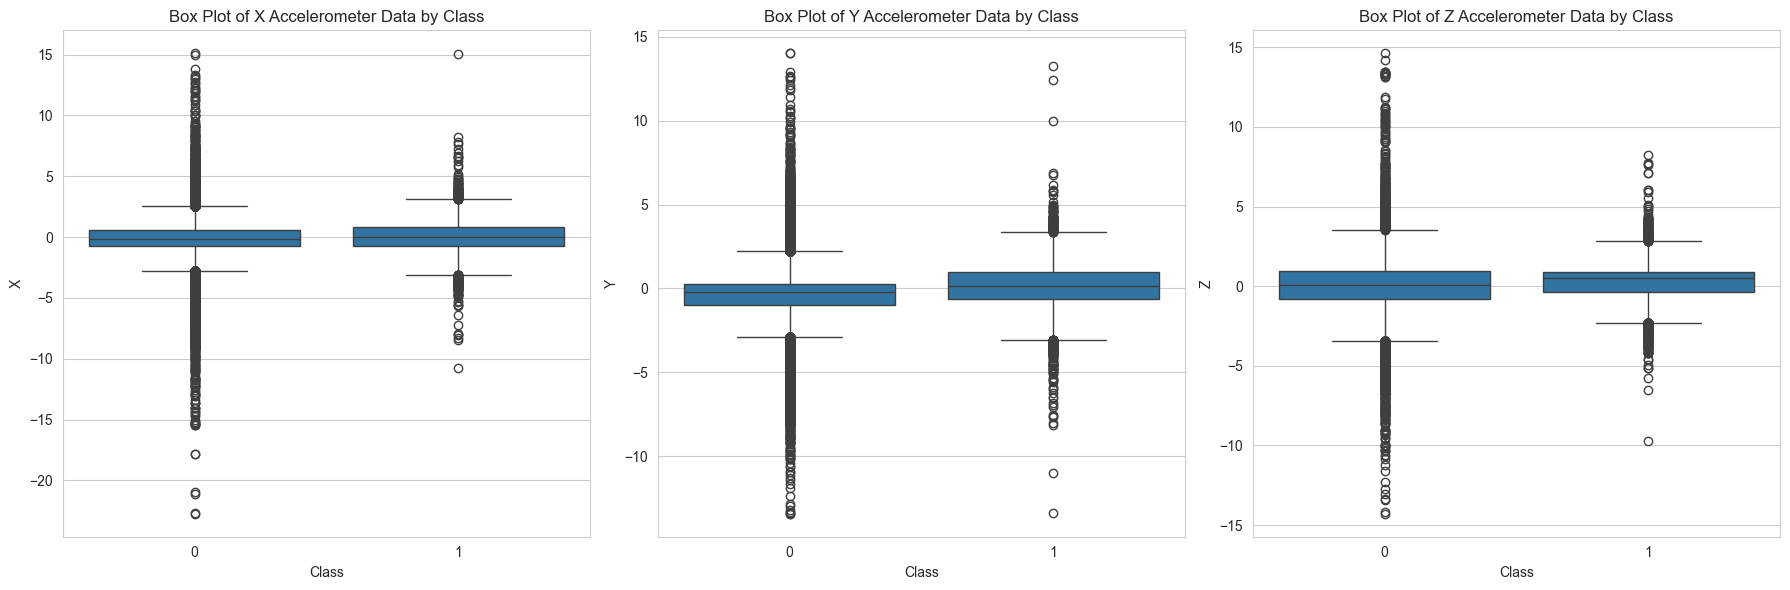

In [4]:
data_x_class_0 = data_x[labels == 0]
data_x_class_1 = data_x[labels == 1]

data_y_class_0 = data_y[labels == 0]
data_y_class_1 = data_y[labels == 1]

data_z_class_0 = data_z[labels == 0]
data_z_class_1 = data_z[labels == 1]

# correlation analysis
data_flat_class_0 = pd.DataFrame({
    'X': data_x_class_0.values.flatten(),
    'Y': data_y_class_0.values.flatten(),
    'Z': data_z_class_0.values.flatten(),
    'Class': '0'
})

data_flat_class_1 = pd.DataFrame({
    'X': data_x_class_1.values.flatten(),
    'Y': data_y_class_1.values.flatten(),
    'Z': data_z_class_1.values.flatten(),
    'Class': '1'
})

data_combined = pd.concat([data_flat_class_0, data_flat_class_1])

sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Class', y='X', data=data_combined)
plt.title('Box Plot of X Accelerometer Data by Class')

plt.subplot(1, 3, 2)
sns.boxplot(x='Class', y='Y', data=data_combined)
plt.title('Box Plot of Y Accelerometer Data by Class')

plt.subplot(1, 3, 3)
sns.boxplot(x='Class', y='Z', data=data_combined)
plt.title('Box Plot of Z Accelerometer Data by Class')

plt.tight_layout()
plt.show()


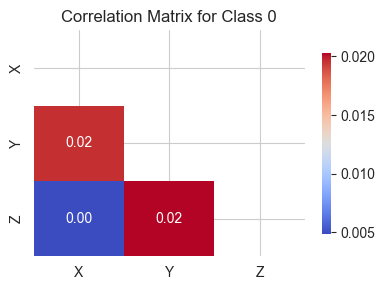

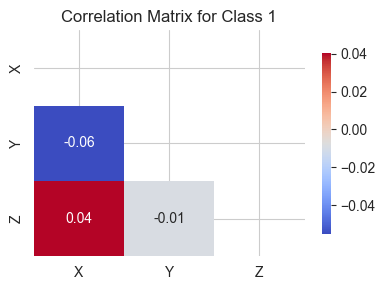

In [5]:
data_flat_class_0 = pd.DataFrame({
    'X': data_x_class_0.values.flatten(),
    'Y': data_y_class_0.values.flatten(),
    'Z': data_z_class_0.values.flatten(),
})

data_flat_class_1 = pd.DataFrame({
    'X': data_x_class_1.values.flatten(),
    'Y': data_y_class_1.values.flatten(),
    'Z': data_z_class_1.values.flatten(),
})
# correlation matrix for each class
correlation_matrix_class_0 = data_flat_class_0.corr()
correlation_matrix_class_1 = data_flat_class_1.corr()

def plot_correlation_matrix(corr_matrix, title):

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(4, 3))
    plt.title(title)

    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                cbar_kws={"shrink": .8})
    plt.tight_layout()

plot_correlation_matrix(correlation_matrix_class_0, 'Correlation Matrix for Class 0')

plot_correlation_matrix(correlation_matrix_class_1, 'Correlation Matrix for Class 1')
plt.show()

In [4]:
## load 5000 rows for now
data_x = pd.read_csv(f'x_train.csv', header=None, nrows=5000)
data_x = pd.read_csv(f'x_train.csv', header=None, nrows=5000)
data_y = pd.read_csv(f'y_train.csv', header=None, nrows=5000)
data_z = pd.read_csv(f'z_train.csv', header=None, nrows=5000)
labels = pd.read_csv(f'label_train.csv', header=None, nrows=5000)
labels = labels.iloc[:, 0]

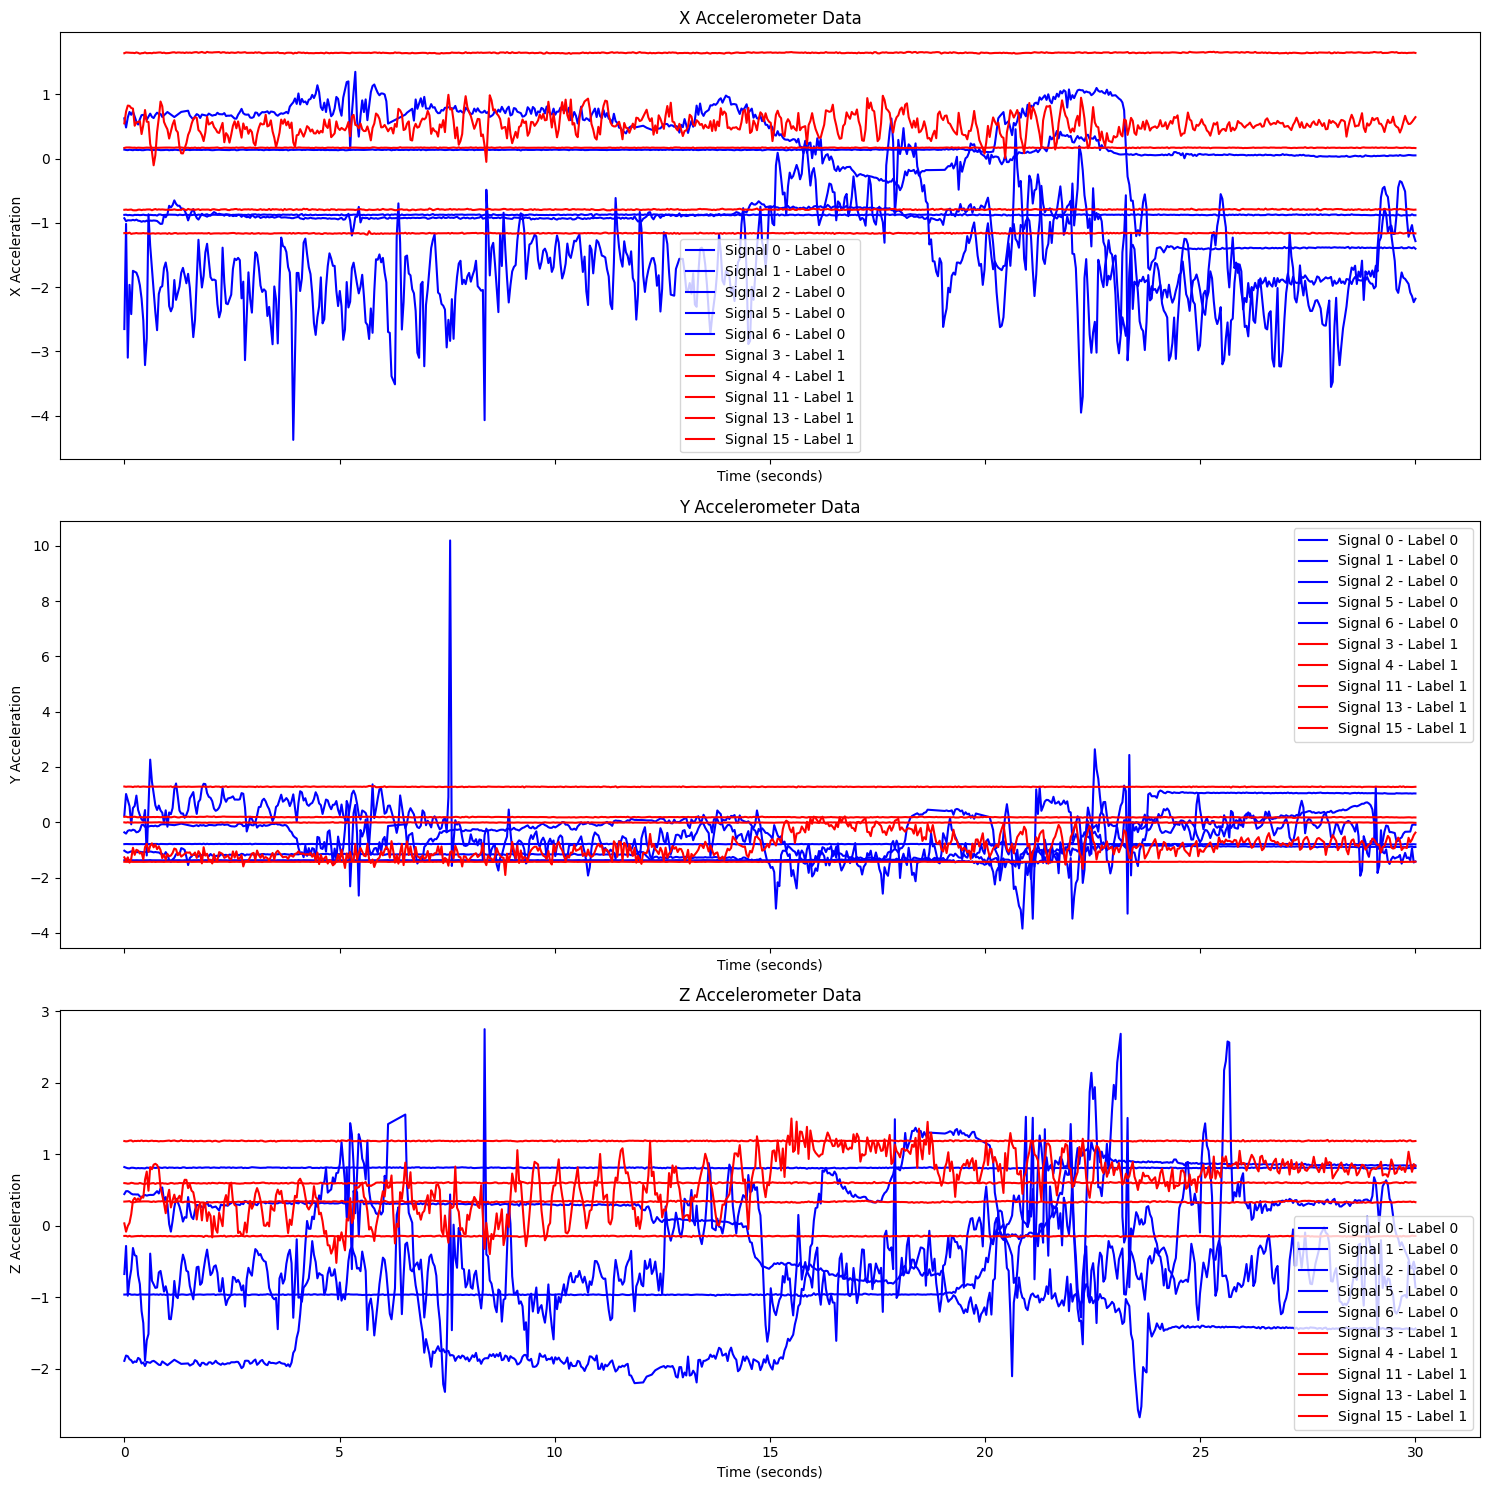

In [5]:
time_vector = np.linspace(0, 30, num=750)

indices_label_0 = labels[labels == 0].index[:5]  # First 5 indices with label 0
indices_label_1 = labels[labels == 1].index[:5]  # First 5 indices with label 1

selected_indices = list(indices_label_0) + list(indices_label_1)


fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

colors = {0: 'blue', 1: 'red'}

def plot_axis_data(axis, data, ax):
    for i in selected_indices:
        ax.plot(time_vector, data.iloc[i, :], color=colors[labels[i]], label=f'Signal {i} - Label {labels[i]}')
    ax.set_title(f'{axis} Accelerometer Data')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(f'{axis} Acceleration')
    ax.legend()

plot_axis_data('X', data_x, axes[0])
plot_axis_data('Y', data_y, axes[1])
plot_axis_data('Z', data_z, axes[2])

plt.tight_layout()
plt.show()

In [6]:
data_combined = np.stack((data_x, data_y, data_z), axis=2)


X_train, X_val, y_train, y_val = train_test_split(data_combined, labels.values, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [7]:
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = 3 # Number of channels
hidden_size = 25  
num_layers = 2  
output_size = 1 #classification

model = LSTMBinaryClassifier(input_size, hidden_size, num_layers, output_size)


In [8]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
number_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {number_of_parameters} parameters')
n_epochs  = 10
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        
        # Training
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * sequences.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
                loss = criterion(outputs.squeeze(), labels)
                total_val_loss += loss.item() * sequences.size(0)
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs)

The model has 8226 parameters
Epoch [1/10], Train Loss: 0.6221, Val Loss: 0.5958
Epoch [2/10], Train Loss: 0.5967, Val Loss: 0.5777
Epoch [3/10], Train Loss: 0.5861, Val Loss: 0.5891
Epoch [4/10], Train Loss: 0.5802, Val Loss: 0.5813
Epoch [5/10], Train Loss: 0.5783, Val Loss: 0.5925
Epoch [6/10], Train Loss: 0.5800, Val Loss: 0.5614
Epoch [7/10], Train Loss: 0.5795, Val Loss: 0.5712
Epoch [8/10], Train Loss: 0.6295, Val Loss: 0.6219
Epoch [9/10], Train Loss: 0.6149, Val Loss: 0.6047
Epoch [10/10], Train Loss: 0.6041, Val Loss: 0.5953


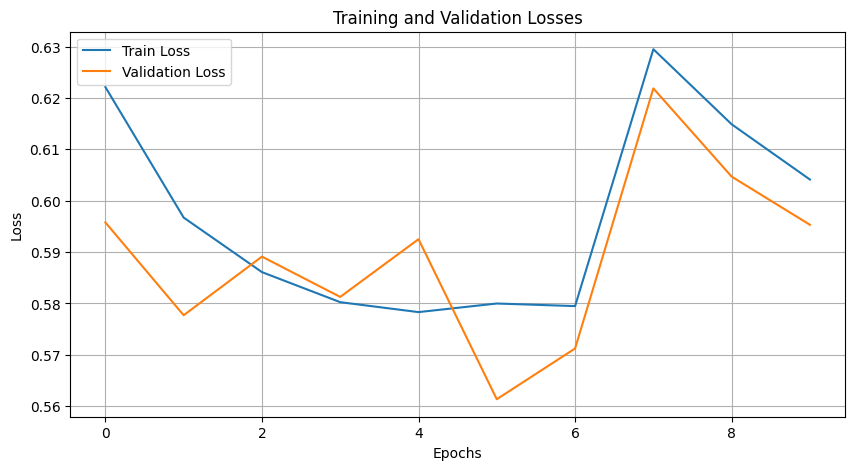

In [9]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [10]:
data_x = pd.read_csv(f'x_test.csv', header=None)
data_y = pd.read_csv(f'y_test.csv', header=None)
data_z = pd.read_csv(f'z_test.csv', header=None)
labels = pd.read_csv(f'label_test.csv', header=None)
labels = labels.iloc[:, 0]
labels = labels.values

In [11]:
X_test = np.stack((data_x, data_y, data_z), axis=2)

X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)

y_pred = []
y_true = []

model.eval()  
with torch.no_grad():
    
    outputs = model(X_test_tensor)
    

probabilities = outputs.numpy()
y_pred = (probabilities > 0.5).astype(int)
y_true = labels  


accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, probabilities)
ap_score = average_precision_score(y_true, probabilities)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision Score: {ap_score:.4f}')

Test Accuracy: 0.5984
Test F1 Score: 0.6995
Test Precision: 0.5588
Test Recall: 0.9348
ROC AUC: 0.7380
Average Precision Score: 0.7306


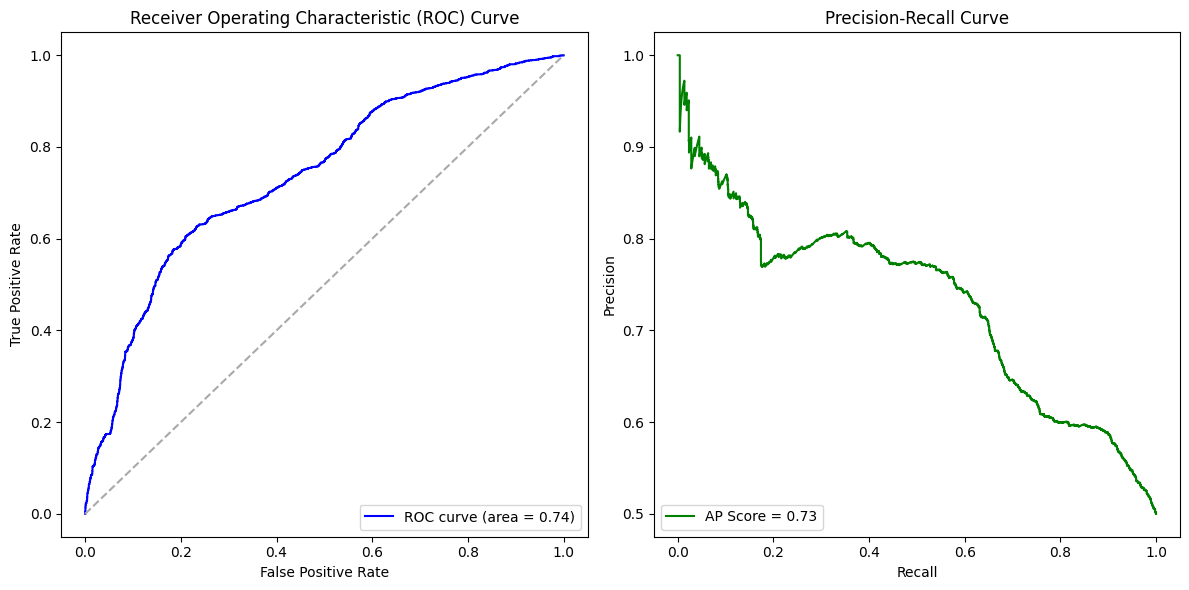

In [12]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, probabilities)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, probabilities)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'AP Score = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()
